In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings


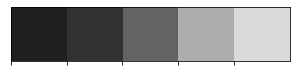

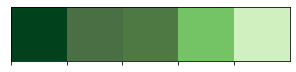

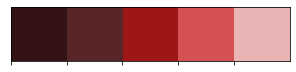

In [2]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [4]:
labels = ['Adialer.C', 'Agent.FYI','Allaple.A','Allaple.L','Alueron.gen!J','Autorun.K','C2LOP.gen!g','C2LOP.P','Dialplatform.B','Dontovo.A','Fakerean',
         'Instantaccess','Lolyda.AA1','Lolyda.AA2','Lolyda.AA3','Lolyda.AT', 'Malex.gen!J', 'Obfuscator.AD', 'Rbot!gen','Skintrim.N','Swizzor.gen!E',
          'Swizzor.gen!I', 'VB.AT', 'Wintrim.BX', 'Yuner.A']

In [6]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join(r'C:\Users\siddh\Downloads\Malware Forensics\Dataset\Malimng\dataset_9010\dataset_9010\malimg_dataset','train',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join(r'C:\Users\siddh\Downloads\Malware Forensics\Dataset\Malimng\dataset_9010\dataset_9010\malimg_dataset','validation',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 25/25 [00:00<00:00, 58.50it/s]


In [8]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [10]:
X_train.shape

(9339, 150, 150, 3)

In [11]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [42]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

C:\Users\siddh\AppData\Local\Temp/ipykernel_9452/1887098240.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  y_train_new.append(labels.index(i))


ValueError: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32) is not in list

In [43]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

In [44]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(25,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)


In [45]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 150, 150, 3)  0           ['input_3[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 150, 150, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                            

In [46]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [47]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [48]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
237/237 [==============================] - ETA: 0s - loss: 0.2063 - accuracy: 0.9446
Epoch 1: val_accuracy improved from -inf to 0.61950, saving model to effnet.h5
237/237 [==============================] - 800s 3s/step - loss: 0.2063 - accuracy: 0.9446 - val_loss: 1.0988 - val_accuracy: 0.6195 - lr: 0.0010
Epoch 2/12
237/237 [==============================] - ETA: 0s - loss: 0.0677 - accuracy: 0.9786
Epoch 2: val_accuracy improved from 0.61950 to 0.73960, saving model to effnet.h5
237/237 [==============================] - 747s 3s/step - loss: 0.0677 - accuracy: 0.9786 - val_loss: 0.7517 - val_accuracy: 0.7396 - lr: 0.0010
Epoch 3/12
237/237 [==============================] - ETA: 0s - loss: 0.0395 - accuracy: 0.9856
Epoch 3: val_accuracy improved from 0.73960 to 0.98811, saving model to effnet.h5
237/237 [==============================] - 732s 3s/step - loss: 0.0395 - accuracy: 0.9856 - val_loss: 0.0439 - val_accuracy: 0.9881 - lr: 0.0010
Epoch 4/12
237/237 [==============

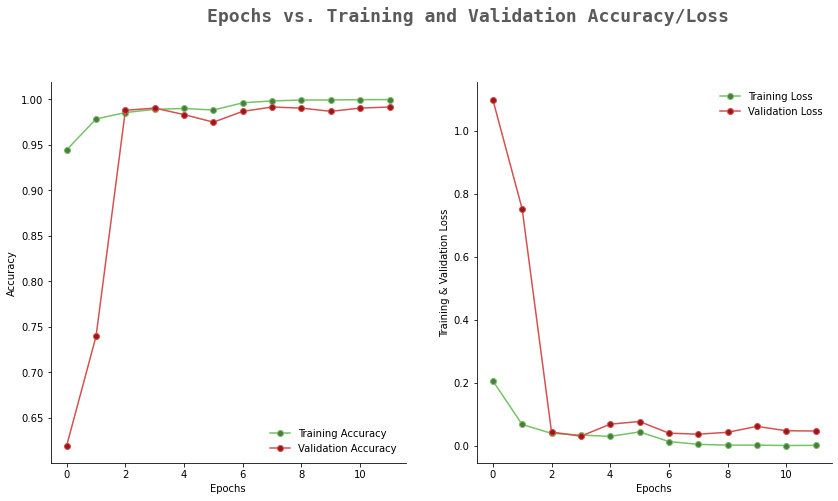

In [49]:
filterwarnings('ignore')

epochs = [i for i in range(12)]
fig, ax = plt.subplots(1,2,figsize=(14,7))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax[0].plot(epochs, train_acc, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label = 'Training Accuracy')
ax[0].plot(epochs, val_acc, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Accuracy')
ax[0].legend(frameon=False)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

sns.despine()
ax[1].plot(epochs, train_loss, marker='o',markerfacecolor=colors_green[2],color=colors_green[3],
           label ='Training Loss')
ax[1].plot(epochs, val_loss, marker='o',markerfacecolor=colors_red[2],color=colors_red[3],
           label = 'Validation Loss')
ax[1].legend(frameon=False)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Training & Validation Loss')

fig.show()

In [50]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

In [51]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00       305
           3       1.00      1.00      1.00       151
           4       1.00      1.00      1.00        26
           5       1.00      1.00      1.00        13
           6       1.00      1.00      1.00        21
           7       0.93      1.00      0.97        14
           8       1.00      1.00      1.00        17
           9       1.00      1.00      1.00        17
          10       1.00      1.00      1.00        36
          11       1.00      1.00      1.00        49
          12       1.00      1.00      1.00        18
          13       1.00      1.00      1.00        18
          14       1.00      1.00      1.00        11
          15       1.00      1.00      1.00        13
          16       1.00      0.94      0.97        16
          17       1.00    

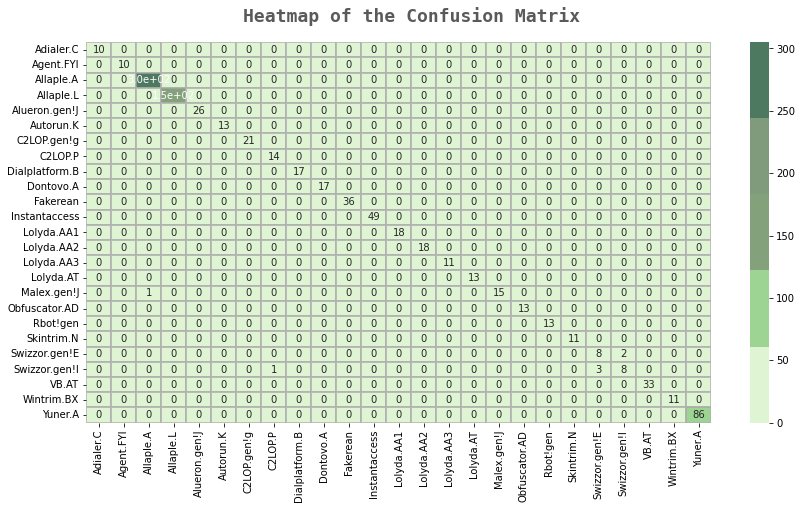

In [52]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,
           cmap=colors_green[::-1],alpha=0.7,linewidths=2,linecolor=colors_dark[3])
fig.text(s='Heatmap of the Confusion Matrix',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)

plt.show()

In [57]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Adialer.C'
    elif p==1:
        p='Agent.FYI'
    elif p==2:
        p='Allaple.A'
    elif p==3:
        p='Allaple.L'
    elif p==4:
        p='Alueron.gen!J'
    elif p==5:
        p='Autorun.K'
    elif p==6:
        p='C2LOP.gen!g'
    elif p==7:
        p='C2LOP.P'
    elif p==8:
        p='Dialplatform.B'
    elif p==10:
        p='Dontovo.A'
    elif p==11:
        p='Fakerean'
    elif p==12:
        p='Instantaccess'
    elif p==13:
        p='Lolyda.AA1'
    elif p==14:
        p='Lolyda.AA2'
    elif p==15:
        p='Lolyda.AA3'
    elif p==16:
        p='Lolyda.AT'
    elif p==17:
        p='Malex.gen!J'
    elif p==18:
        p='Obfuscator.AD'
    elif p==19:
        p='Rbot!gen'
    elif p==20:
        p='Skintrim.N'
    elif p==21:
        p='Swizzor.gen!E'
    elif p==22:
        p='Swizzor.gen!I'
    elif p==23:
        p='VB.AT'
    elif p==24:
        p='Wintrim.BX'
    else:
        p='Yuner.A'   
        
        

    if p!=1:
        print(f'The Model predicts that it is a {p}')

In [58]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [59]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)
            
        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])